# Machine Learning Engineer Nanodegree
## Reinforcement Learning

# &#x1F4D1; &nbsp; P4: Train a Smartcab to Drive

## Getting Started
In this project, we will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.
### Code Library and Links

In [3]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: #fee6cf;} 
a {color: #fd8311; font-family: 'Roboto';} 
h1 {color: #f05e1c; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #f05e1c; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #fd8311;}      
div.output_stderr pre {background-color: #fee6cf;}  
div.output_stderr {background-color: slategrey;}                        
</style>
<script>
code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    };
    code_show = !code_show;
} 
$(document).ready(code_display);
</script>
<form action="javascript: code_display()">
<input style="color: #f05e1c; background: #fee6cf; opacity: 0.8;" \ 
type="submit" value="Click to display or hide code cells">
</form>

In [4]:
hide_code = ''
# Import libraries 
import numpy as np
import pandas as pd

import random
import math

import seaborn as sns 
import pylab as plt

import time
import os
import ast
import importlib
import csv

from IPython.display import display, HTML, IFrame
from collections import OrderedDict

import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")

from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

In [3]:
hide_code
# https://github.com/udacity/machine-learning/blob/master/projects/smartcab/visuals.py

def calculate_safety(data):
    """ Calculates the safety rating of the smartcab during testing. """

    good_ratio = data['good_actions'].sum() * 1.0 / \
    (data['initial_deadline'] - data['final_deadline']).sum()

    if good_ratio == 1: # Perfect driving
        return ("A+", "green")
    else: # Imperfect driving
        if data['actions'].apply(lambda x: ast.literal_eval(x)[4]).sum() > 0: # Major accident
            return ("F", "red")
        elif data['actions'].apply(lambda x: ast.literal_eval(x)[3]).sum() > 0: # Minor accident
            return ("D", "#EEC700")
        elif data['actions'].apply(lambda x: ast.literal_eval(x)[2]).sum() > 0: # Major violation
            return ("C", "#EEC700")
        else: # Minor violation
            minor = data['actions'].apply(lambda x: ast.literal_eval(x)[1]).sum()
            if minor >= len(data)/2: # Minor violation in at least half of the trials
                return ("B", "green")
            else:
                return ("A", "green")

def calculate_reliability(data):
    """ Calculates the reliability rating of the smartcab during testing. """
    
    success_ratio = data['success'].sum() * 1.0 / len(data)

    if success_ratio == 1: # Always meets deadline
        return ("A+", "green")
    else:
        if success_ratio >= 0.90:
            return ("A", "green")
        elif success_ratio >= 0.80:
            return ("B", "green")
        elif success_ratio >= 0.70:
            return ("C", "#EEC700")
        elif success_ratio >= 0.60:
            return ("D", "#EEC700")
        else:
            return ("F", "red")

def plot_trials(csv):
    """ Plots the data from logged metrics during a simulation."""

    data = pd.read_csv(os.path.join("logs2", csv))

    if len(data) < 10:
        print "Not enough data collected to create a visualization."
        print "At least 20 trials are required."
        return
 
    # Create additional features
    data['average_reward'] = (data['net_reward'] / \
        (data['initial_deadline'] - data['final_deadline'])).rolling(window=10, center=False).mean()
    # compute avg. net reward with window=10
    data['reliability_rate'] = (data['success']*100).rolling(window=10, center=False).mean()  

    data['good_actions'] = data['actions'].apply(lambda x: ast.literal_eval(x)[0])
    
    data['good'] = (data['good_actions'] * 1.0 / \
        (data['initial_deadline'] - data['final_deadline'])).rolling(window=10, center=False).mean()
    data['minor'] = (data['actions'].apply(lambda x: ast.literal_eval(x)[1]) * 1.0 / \
        (data['initial_deadline'] - data['final_deadline'])).rolling(window=10, center=False).mean()
    data['major'] = (data['actions'].apply(lambda x: ast.literal_eval(x)[2]) * 1.0 / \
        (data['initial_deadline'] - data['final_deadline'])).rolling(window=10, center=False).mean()
    data['minor_acc'] = (data['actions'].apply(lambda x: ast.literal_eval(x)[3]) * 1.0 / \
        (data['initial_deadline'] - data['final_deadline'])).rolling(window=10, center=False).mean()
    data['major_acc'] = (data['actions'].apply(lambda x: ast.literal_eval(x)[4]) * 1.0 / \
        (data['initial_deadline'] - data['final_deadline'])).rolling(window=10, center=False).mean()
    
    data['epsilon'] = data['parameters'].apply(lambda x: ast.literal_eval(x)['e']) 
    data['alpha'] = data['parameters'].apply(lambda x: ast.literal_eval(x)['a']) 

    # Create training and testing subsets
    training_data = data[data['testing'] == False]
    testing_data = data[data['testing'] == True]

    plt.figure(figsize=(14,8))

    ############################
    ### Average step reward plot
    ############################
 
    ax = plt.subplot2grid((6,6), (0,3), colspan=3, rowspan=2)
    ax.set_title("10-Trial Rolling Average Reward per Action")
    ax.set_ylabel("Reward per Action")
    ax.set_xlabel("Trial Number")
    ax.set_xlim((10, len(training_data)))

    # Create plot-specific data
    step = training_data[['trial','average_reward']].dropna()

    ax.axhline(xmin = 0, xmax = 1, y = 0, color = 'black', linestyle = 'dashed')
    ax.plot(step['trial'], step['average_reward'])

    ####################
    ### Parameters Plot
    ####################

    ax = plt.subplot2grid((6,6), (2,3), colspan=3, rowspan=2)

    # Check whether the agent was expected to learn
    if csv != 'sim_no-learning.csv':
        ax.set_ylabel("Parameter Value")
        ax.set_xlabel("Trial Number")
        ax.set_xlim((1, len(training_data)))
        ax.set_ylim((0, 1.05))

        ax.plot(training_data['trial'], training_data['epsilon'], color='blue', label='Exploration factor')
        ax.plot(training_data['trial'], training_data['alpha'], color='green', label='Learning factor')

        ax.legend(bbox_to_anchor=(0.5,1.19), fancybox=True, ncol=2, loc='upper center', fontsize=10)

    else:
        ax.axis('off')
        ax.text(0.52, 0.30, "Simulation completed\nwith learning disabled.", 
                fontsize=24, ha='center', style='italic')

    ####################
    ### Bad Actions Plot
    ####################

    actions = training_data[['trial','good', 'minor','major','minor_acc','major_acc']].dropna()
    maximum = (1 - actions['good']).values.max()
 
    ax = plt.subplot2grid((6,6), (0,0), colspan=3, rowspan=4)
    ax.set_title("10-Trial Rolling Relative Frequency of Bad Actions")
    ax.set_ylabel("Relative Frequency")
    ax.set_xlabel("Trial Number")

    ax.set_ylim((0, maximum + 0.01))
    ax.set_xlim((10, len(training_data)))

    ax.set_yticks(np.linspace(0, maximum+0.01, 10))

    ax.plot(actions['trial'], (1 - actions['good']), color='darkgreen', 
            label='Total Bad Actions', linestyle='dotted', linewidth=3)
    ax.plot(actions['trial'], actions['minor'], color='orange', 
            label='Minor Violation', linestyle='dashed')
    ax.plot(actions['trial'], actions['major'], color='orange', 
            label='Major Violation', linewidth=2)
    ax.plot(actions['trial'], actions['minor_acc'], color='red', 
            label='Minor Accident', linestyle='dashed')
    ax.plot(actions['trial'], actions['major_acc'], color='red', 
            label='Major Accident', linewidth=2)

    ax.legend(loc='upper right', fancybox=True, fontsize=10)

    #############################
    ### Rolling Success-Rate plot
    #############################

    ax = plt.subplot2grid((6,6), (4,0), colspan=4, rowspan=2)
    ax.set_title("10-Trial Rolling Rate of Reliability")
    ax.set_ylabel("Rate of Reliability")
    ax.set_xlabel("Trial Number")
    ax.set_xlim((10, len(training_data)))
    ax.set_ylim((-5, 105))
    ax.set_yticks(np.arange(0, 101, 20))
    ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

    # Create plot-specific data
    trial = training_data.dropna()['trial']
    rate = training_data.dropna()['reliability_rate']

    # Rolling success rate
    ax.plot(trial, rate, label="Reliability Rate", color='blue')

    ################
    ### Test results
    ################

    ax = plt.subplot2grid((6,6), (4,4), colspan=2, rowspan=2)
    ax.axis('off')

    if len(testing_data) > 0:
        safety_rating, safety_color = calculate_safety(testing_data)
        reliability_rating, reliability_color = calculate_reliability(testing_data)

        # Write success rate
        ax.text(0.40, .9, "{} testing trials simulated.".format(len(testing_data)), fontsize=14, ha='center')
        ax.text(0.40, 0.7, "Safety Rating:", fontsize=16, ha='center')
        ax.text(0.40, 0.42, "{}".format(safety_rating), fontsize=40, ha='center', color=safety_color)
        ax.text(0.40, 0.27, "Reliability Rating:", fontsize=16, ha='center')
        ax.text(0.40, 0, "{}".format(reliability_rating), fontsize=40, ha='center', color=reliability_color)

    else:
        ax.text(0.36, 0.30, "Simulation completed\nwith testing disabled.", 
                fontsize=20, ha='center', style='italic')	

    plt.tight_layout()
    plt.show()

In [4]:
hide_code
# https://github.com/udacity/machine-learning/blob/master/projects/smartcab/smartcab/simulator.py

class Simulator(object):
    """
       Simulates agents in a dynamic smartcab environment.
       Uses PyGame to display GUI, if available.
    """
    colors = {
        'black'   : (  32,   32,   51),
        'white'   : (255, 255, 255),
        'red'     : (255,   32,   32),
        'green'   : (  0, 255,   0),
        'dgreen'  : (  0, 228,   0),
        'blue'    : (  0,   0, 255),
        'cyan'    : (  0, 200, 200),
        'magenta' : (200,   0, 200),
        'yellow'  : (255, 255,   102),
        'mustard' : (200, 200,   0),
        'orange'  : (255, 128,   0),
        'maroon'  : (200,   0,   0),
        'crimson' : (128,   0,   0),
        'gray'    : (192, 192, 192)
    }

    def __init__(self, env, size=None, update_delay=2.0, display=True, log_metrics=False, optimized=False):
        self.env = env
        self.size = size if size is not None else ((self.env.grid_size[0] + 1) * \
                                                   self.env.block_size, (self.env.grid_size[1] + 2) * \
                                                   self.env.block_size)
        self.width, self.height = self.size
        self.road_width = 44

        self.bg_color = self.colors['gray']
        self.road_color = self.colors['black']
        self.line_color = self.colors['mustard']
        self.boundary = self.colors['black']
        self.stop_color = self.colors['crimson']

        self.quit = False
        self.start_time = None
        self.current_time = 0.0
        self.last_updated = 0.0
        self.update_delay = update_delay  # duration between each step (in seconds)

        self.display = display
        if self.display:
            try:
                self.pygame = importlib.import_module('pygame')
                self.pygame.init()
                self.screen = self.pygame.display.set_mode(self.size)
                
                self._logo = self.pygame.transform.\
                smoothscale(self.pygame.image.load(os.path.join("images", "logo.png")), 
                            (self.road_width, self.road_width))

                self._ew = self.pygame.transform.\
                smoothscale(self.pygame.image.load(os.path.join("images", "east-west.png")), 
                            (self.road_width, self.road_width))
                
                self._ns = self.pygame.transform.\
                smoothscale(self.pygame.image.load(os.path.join("images", "north-south.png")), 
                            (self.road_width, self.road_width))

                self.frame_delay = max(1, int(self.update_delay * 1000))  # delay between GUI frames in ms (min: 1)
                self.agent_sprite_size = (32, 32)
                self.primary_agent_sprite_size = (42, 42)
                self.agent_circle_radius = 20  # radius of circle, when using simple representation
                for agent in self.env.agent_states:
                    if agent.color == 'white':
                        agent._sprite = self.pygame.transform.\
                        smoothscale(self.pygame.image.load(os.path.join("images", "car-{}.png".format(agent.color))), 
                                    self.primary_agent_sprite_size)
                    else:
                        agent._sprite = self.pygame.transform.\
                        smoothscale(self.pygame.image.load(os.path.join("images", "car-{}.png".format(agent.color))), 
                                    self.agent_sprite_size)
                    agent._sprite_size = (agent._sprite.get_width(), agent._sprite.get_height())

                self.font = self.pygame.font.Font(None, 20)
                self.paused = False
            except ImportError as e:
                self.display = False
                print "Simulator.__init__(): Unable to import pygame; display disabled.\n{}: {}".\
                format(e.__class__.__name__, e)
            except Exception as e:
                self.display = False
                print "Simulator.__init__(): Error initializing GUI objects; display disabled.\n{}: {}".\
                format(e.__class__.__name__, e)

        # Setup metrics to report
        self.log_metrics = log_metrics
        self.optimized = optimized
        
        if self.log_metrics:
            a = self.env.primary_agent

            # Set log files
            if a.learning:
                if self.optimized: # Whether the user is optimizing the parameters and decay functions
                    self.log_filename = os.path.join("logs2", "sim_improved-learning.csv")
                    self.table_filename = os.path.join("logs2","sim_improved-learning.txt")
                else: 
                    self.log_filename = os.path.join("logs2", "sim_default-learning.csv")
                    self.table_filename = os.path.join("logs2","sim_default-learning.txt")

                self.table_file = open(self.table_filename, 'wb')
            else:
                self.log_filename = os.path.join("logs2", "sim_no-learning.csv")
            
            self.log_fields = ['trial', 'testing', 'parameters', 'initial_deadline', 
                               'final_deadline', 'net_reward', 'actions', 'success']
            self.log_file = open(self.log_filename, 'wb')
            self.log_writer = csv.DictWriter(self.log_file, fieldnames=self.log_fields)
            self.log_writer.writeheader()

    def run(self, tolerance=0.05, n_test=0):
        """ Run a simulation of the environment. 

        'tolerance' is the minimum epsilon necessary to begin testing (if enabled)
        'n_test' is the number of testing trials simulated

        Note that the minimum number of training trials is always 20. """

        self.quit = False

        # Get the primary agent
        a = self.env.primary_agent

        total_trials = 1
        testing = False
        trial = 1

        while True:

            # Flip testing switch
            if not testing:
                if total_trials > 20: # Must complete minimum 20 training trials
                    if a.learning:
                        if a.epsilon < tolerance: # assumes epsilon decays to 0
                            testing = True
                            trial = 1
                    else:
                        testing = True
                        trial = 1
                        
            # Break if we've reached the limit of testing trials
            else:
                if trial > n_test:
                    break

            # Pretty print to terminal
            print 
            print "/-------------------------"
            if testing:
                print "| Testing trial {}".format(trial)
            else:
                print "| Training trial {}".format(trial)

            print "\-------------------------"
            print 

            self.env.reset(testing)
            self.current_time = 0.0
            self.last_updated = 0.0
            self.start_time = time.time()
            while True:
                try:
                    # Update current time
                    self.current_time = time.time() - self.start_time

                    # Handle GUI events
                    if self.display:
                        for event in self.pygame.event.get():
                            if event.type == self.pygame.QUIT:
                                self.quit = True
                            elif event.type == self.pygame.KEYDOWN:
                                if event.key == 27:  # Esc
                                    self.quit = True
                                elif event.unicode == u' ':
                                    self.paused = True

                        if self.paused:
                            self.pause()

                    # Update environment
                    if self.current_time - self.last_updated >= self.update_delay:
                        self.env.step()
                        self.last_updated = self.current_time
                    
                    # Render text
                    self.render_text(trial, testing)

                    # Render GUI and sleep
                    if self.display:
                        self.render(trial, testing)
                        self.pygame.time.wait(self.frame_delay)

                except KeyboardInterrupt:
                    self.quit = True
                finally:
                    if self.quit or self.env.done:
                        break

            if self.quit:
                break

            # Collect metrics from trial
            if self.log_metrics:
                self.log_writer.writerow({
                    'trial': trial,
                    'testing': self.env.trial_data['testing'],
                    'parameters': self.env.trial_data['parameters'],
                    'initial_deadline': self.env.trial_data['initial_deadline'],
                    'final_deadline': self.env.trial_data['final_deadline'],
                    'net_reward': self.env.trial_data['net_reward'],
                    'actions': self.env.trial_data['actions'],
                    'success': self.env.trial_data['success']
                })

            # Trial finished
            if self.env.success == True:
                print "\nTrial Completed!"
                print "Agent reached the destination."
            else:
                print "\nTrial Aborted!"
                print "Agent did not reach the destination."

            # Increment
            total_trials = total_trials + 1
            trial = trial + 1

        # Clean up
        if self.log_metrics:

            if a.learning:
                f = self.table_file
                
                f.write("/-----------------------------------------\n")
                f.write("| State-action rewards from Q-Learning\n")
                f.write("\-----------------------------------------\n\n")

                for state in a.Q:
                    f.write("{}\n".format(state))
                    for action, reward in a.Q[state].iteritems():
                        f.write(" -- {} : {:.2f}\n".format(action, reward))
                    f.write("\n")  
                self.table_file.close()

            self.log_file.close()

        print "\nSimulation ended. . . "

        # Report final metrics
        if self.display:
            self.pygame.display.quit()  # shut down pygame

    def render_text(self, trial, testing=False):
        """ This is the non-GUI render display of the simulation. 
            Simulated trial data will be rendered in the terminal/command prompt. """

        status = self.env.step_data
        if status and status['waypoint'] is not None: # Continuing the trial

            # Previous State
            if status['state']:
                print "Agent previous state: {}".format(status['state'])
            else:
                print "!! Agent state not been updated!"

            # Result
            if status['violation'] == 0: # Legal
                if status['waypoint'] == status['action']: # Followed waypoint
                    print "Agent followed the waypoint {}. (rewarded {:.2f})".format(status['action'], 
                                                                                     status['reward'])
                elif status['action'] == None:
                    if status['light'] == 'red': # Stuck at red light
                        print "Agent properly idled at a red light. (rewarded {:.2f})".format(status['reward'])
                    else:
                        print "Agent idled at a green light with oncoming traffic. (rewarded {:.2f})".\
                        format(status['reward'])
                else: # Did not follow waypoint
                    print "Agent drove {} instead of {}. (rewarded {:.2f})".\
                    format(status['action'], status['waypoint'], status['reward'])
            else: # Illegal
                if status['violation'] == 1: # Minor violation
                    print "Agent idled at a green light with no oncoming traffic. (rewarded {:.2f})".\
                    format(status['reward'])
                elif status['violation'] == 2: # Major violation
                    print "Agent attempted driving {} through a red light. (rewarded {:.2f})".\
                    format(status['action'], status['reward'])
                elif status['violation'] == 3: # Minor accident
                    print "Agent attempted driving {} through traffic and cause a minor accident. (rewarded {:.2f})".\
                    format(status['action'], status['reward'])
                elif status['violation'] == 4: # Major accident
                    print "Agent attempted driving {} through a red light with traffic and cause a major accident. \
                    (rewarded {:.2f})".format(status['action'], status['reward'])
           
            # Time Remaining
            if self.env.enforce_deadline:
                time = (status['deadline'] - 1) * 100.0 / (status['t'] + status['deadline'])
                print "{:.0f}% of time remaining to reach destination.".format(time)
            else:
                print "Agent not enforced to meet deadline."

        # Starting new trial
        else:
            a = self.env.primary_agent
            print "Simulating trial. . . "
            if a.learning:
                print "epsilon = {:.4f}; alpha = {:.4f}".format(a.epsilon, a.alpha)
            else:
                print "Agent not set to learn."

                
    def render(self, trial, testing=False):
        """ This is the GUI render display of the simulation. 
            Supplementary trial data can be found from render_text. """
        
        # Reset the screen.
        self.screen.fill(self.bg_color)

        # Draw elements
        # * Static elements

        # Boundary
        self.pygame.draw.rect(self.screen, self.boundary, 
                              ((self.env.bounds[0] - self.env.hang)*self.env.block_size, 
                               (self.env.bounds[1]-self.env.hang)*self.env.block_size, 
                               (self.env.bounds[2] + self.env.hang/3)*self.env.block_size, 
                               (self.env.bounds[3] - 1 + self.env.hang/3)*self.env.block_size), 4)
        
        for road in self.env.roads:
            # Road
            self.pygame.draw.line(self.screen, self.road_color, 
                                  (road[0][0] * self.env.block_size, road[0][1] * self.env.block_size), 
                                  (road[1][0] * self.env.block_size, road[1][1] * self.env.block_size), 
                                  self.road_width)
            # Center line
            self.pygame.draw.line(self.screen, self.line_color, 
                                  (road[0][0] * self.env.block_size, road[0][1] * self.env.block_size), 
                                  (road[1][0] * self.env.block_size, road[1][1] * self.env.block_size), 2)
        
        for intersection, traffic_light in self.env.intersections.iteritems():
            self.pygame.draw.circle(self.screen, self.road_color, 
                                    (intersection[0] * self.env.block_size, 
                                     intersection[1] * self.env.block_size), self.road_width/2)
            
            if traffic_light.state: # North-South is open
                self.screen.blit(self._ns,
                    self.pygame.rect.Rect(intersection[0]*self.env.block_size - self.road_width/2, 
                                          intersection[1]*self.env.block_size - self.road_width/2, 
                                          intersection[0]*self.env.block_size + self.road_width, 
                                          intersection[1]*self.env.block_size + self.road_width/2))
                self.pygame.draw.line(self.screen, self.stop_color, 
                                      (intersection[0] * self.env.block_size - self.road_width/2, 
                                       intersection[1] * self.env.block_size - self.road_width/2), 
                                      (intersection[0] * self.env.block_size - self.road_width/2, 
                                       intersection[1] * self.env.block_size + self.road_width/2), 2)
                self.pygame.draw.line(self.screen, self.stop_color, 
                                      (intersection[0] * self.env.block_size + self.road_width/2 + 1, 
                                       intersection[1] * self.env.block_size - self.road_width/2), 
                                      (intersection[0] * self.env.block_size + self.road_width/2 + 1, 
                                       intersection[1] * self.env.block_size + self.road_width/2), 2)            
            else:
                self.screen.blit(self._ew,
                    self.pygame.rect.Rect(intersection[0]*self.env.block_size - self.road_width/2, 
                                          intersection[1]*self.env.block_size - self.road_width/2, 
                                          intersection[0]*self.env.block_size + self.road_width, 
                                          intersection[1]*self.env.block_size + self.road_width/2))
                self.pygame.draw.line(self.screen, self.stop_color, 
                                      (intersection[0] * self.env.block_size - self.road_width/2, 
                                       intersection[1] * self.env.block_size - self.road_width/2), 
                                      (intersection[0] * self.env.block_size + self.road_width/2, 
                                       intersection[1] * self.env.block_size - self.road_width/2), 2)
                self.pygame.draw.line(self.screen, self.stop_color, 
                                      (intersection[0] * self.env.block_size + self.road_width/2, 
                                       intersection[1] * self.env.block_size + self.road_width/2 + 1), 
                                      (intersection[0] * self.env.block_size - self.road_width/2, 
                                       intersection[1] * self.env.block_size + self.road_width/2 + 1), 2)            
            
        # * Dynamic elements
        self.font = self.pygame.font.Font(None, 20)
        for agent, state in self.env.agent_states.iteritems():
            # Compute precise agent location here (back from the intersection some)
            agent_offset = (2 * state['heading'][0] * self.agent_circle_radius + \
                            self.agent_circle_radius * state['heading'][1] * 0.5, \
                            2 * state['heading'][1] * self.agent_circle_radius - \
                            self.agent_circle_radius * state['heading'][0] * 0.5)


            agent_pos = (state['location'][0] * self.env.block_size - agent_offset[0], 
                         state['location'][1] * self.env.block_size - agent_offset[1])
            agent_color = self.colors[agent.color]

            if hasattr(agent, '_sprite') and agent._sprite is not None:
                # Draw agent sprite (image), properly rotated
                rotated_sprite = agent._sprite \
                if state['heading'] == (1, 0) \
                else self.pygame.transform.rotate(agent._sprite, 
                                                  180 if state['heading'][0] == -1 else state['heading'][1] * -90)
                self.screen.blit(rotated_sprite,
                    self.pygame.rect.Rect(agent_pos[0] - agent._sprite_size[0] / 2, 
                                          agent_pos[1] - agent._sprite_size[1] / 2,
                        agent._sprite_size[0], agent._sprite_size[1]))
            else:
                # Draw simple agent (circle with a short line segment poking out to indicate heading)
                self.pygame.draw.circle(self.screen, agent_color, agent_pos, self.agent_circle_radius)
                self.pygame.draw.line(self.screen, agent_color, agent_pos, state['location'], self.road_width)
            

            if state['destination'] is not None:
                self.screen.blit(self._logo,
                    self.pygame.rect.Rect(state['destination'][0] * self.env.block_size - self.road_width/2, \
                        state['destination'][1]*self.env.block_size - self.road_width/2, \
                        state['destination'][0]*self.env.block_size + self.road_width/2, \
                        state['destination'][1]*self.env.block_size + self.road_width/2))

        # * Overlays
        self.font = self.pygame.font.Font(None, 50)
        if testing:
            self.screen.blit(self.font.render("Testing Trial %s"%(trial), True, 
                                              self.colors['black'], self.bg_color), (10, 10))
        else:
            self.screen.blit(self.font.render("Training Trial %s"%(trial), True, 
                                              self.colors['black'], self.bg_color), (10, 10))

        self.font = self.pygame.font.Font(None, 30)

        # Status text about each step
        status = self.env.step_data
        if status:

            # Previous State
            if status['state']:
                self.screen.blit(self.font.render("Previous State: {}".format(status['state']), True, 
                                                  self.colors['white'], self.bg_color), (350, 10))
            if not status['state']:
                self.screen.blit(self.font.render("!! Agent state not updated!", True, 
                                                  self.colors['maroon'], self.bg_color), (350, 10))

            # Action
            if status['violation'] == 0: # Legal
                if status['action'] == None:
                    self.screen.blit(self.font.render("No action taken. (rewarded {:.2f})".\
                                                      format(status['reward']), True, self.colors['dgreen'], 
                                                      self.bg_color), (350, 40))
                else:
                    self.screen.blit(self.font.render("Agent drove {}. (rewarded {:.2f})".\
                                                      format(status['action'], status['reward']), True, 
                                                      self.colors['dgreen'], self.bg_color), (350, 40))
            else: # Illegal
                if status['action'] == None:
                    self.screen.blit(self.font.render("No action taken. (rewarded {:.2f})".\
                                                      format(status['reward']), True, self.colors['maroon'], 
                                                      self.bg_color), (350, 40))
                else:
                    self.screen.blit(self.font.render("{} attempted (rewarded {:.2f})".\
                                                      format(status['action'], status['reward']), True, 
                                                      self.colors['maroon'], self.bg_color), (350, 40))

            # Result
            if status['violation'] == 0: # Legal
                if status['waypoint'] == status['action']: # Followed waypoint
                    self.screen.blit(self.font.render("Agent followed the waypoint!", True, 
                                                      self.colors['dgreen'], self.bg_color), (350, 70))
                elif status['action'] == None:
                    if status['light'] == 'red': # Stuck at a red light
                        self.screen.blit(self.font.render("Agent idled at a red light!", True, 
                                                          self.colors['dgreen'], self.bg_color), (350, 70))
                    else:
                        self.screen.blit(self.font.render("Agent idled at a green light with oncoming traffic.", 
                                                          True, self.colors['mustard'], self.bg_color), (350, 70))
                else: # Did not follow waypoint
                    self.screen.blit(self.font.render("Agent did not follow the waypoint.", True, 
                                                      self.colors['mustard'], self.bg_color), (350, 70))
            else: # Illegal
                if status['violation'] == 1: # Minor violation
                    self.screen.blit(self.font.render("There was a green light with no oncoming traffic.", 
                                                      True, self.colors['maroon'], self.bg_color), (350, 70))
                elif status['violation'] == 2: # Major violation
                    self.screen.blit(self.font.render("There was a red light with no traffic.", 
                                                      True, self.colors['maroon'], self.bg_color), (350, 70))
                elif status['violation'] == 3: # Minor accident
                    self.screen.blit(self.font.render("There was traffic with right-of-way.", 
                                                      True, self.colors['maroon'], self.bg_color), (350, 70))
                elif status['violation'] == 4: # Major accident
                    self.screen.blit(self.font.render("There was a red light with traffic.", 
                                                      True, self.colors['maroon'], self.bg_color), (350, 70))

            # Time Remaining
            if self.env.enforce_deadline:
                time = (status['deadline'] - 1) * 100.0 / (status['t'] + status['deadline'])
                self.screen.blit(self.font.render("{:.0f}% of time remaining to reach destination.".\
                                                  format(time), True, self.colors['black'], 
                                                  self.bg_color), (350, 100))
            else:
                self.screen.blit(self.font.render("Agent not enforced to meet deadline.", 
                                                  True, self.colors['black'], self.bg_color), (350, 100))
            
            # Denote whether a trial was a success or failure
            if (state['destination'] != state['location'] and state['deadline'] > 0) or \
            (self.env.enforce_deadline is not True and state['destination'] != state['location']):
                self.font = self.pygame.font.Font(None, 40)
                if self.env.success == True:
                    self.screen.blit(self.font.render("Previous Trial: Success", 
                                                      True, self.colors['dgreen'], self.bg_color), (10, 50))
                if self.env.success == False:
                    self.screen.blit(self.font.render("Previous Trial: Failure", 
                                                      True, self.colors['maroon'], self.bg_color), (10, 50))

                if self.env.primary_agent.learning:
                    self.font = self.pygame.font.Font(None, 22)
                    self.screen.blit(self.font.render("epsilon = {:.4f}".format(self.env.primary_agent.epsilon), 
                                                      True, self.colors['black'], self.bg_color), (10, 80))
                    self.screen.blit(self.font.render("alpha = {:.4f}".format(self.env.primary_agent.alpha), 
                                                      True, self.colors['black'], self.bg_color), (10, 95))

        # Reset status text
        else:
            self.pygame.rect.Rect(350, 10, self.width, 200)
            self.font = self.pygame.font.Font(None, 40)
            self.screen.blit(self.font.render("Simulating trial. . .", True, 
                                              self.colors['white'], self.bg_color), (400, 60))

        # Flip buffers
        self.pygame.display.flip()

    def pause(self):
        """ When the GUI is enabled, this function will pause the simulation. """
        
        abs_pause_time = time.time()
        self.font = self.pygame.font.Font(None, 30)
        pause_text = "Simulation Paused. Press any key to continue. . ."
        self.screen.blit(self.font.render(pause_text, True, self.colors['red'], self.bg_color), 
                         (400, self.height - 30))
        self.pygame.display.flip()
        print pause_text
        while self.paused:
            for event in self.pygame.event.get():
                if event.type == self.pygame.KEYDOWN:
                    self.paused = False
            self.pygame.time.wait(self.frame_delay)
        self.screen.blit(self.font.render(pause_text, True, self.bg_color, self.bg_color), 
                         (400, self.height - 30))
        self.start_time += (time.time() - abs_pause_time)

In [5]:
hide_code
# https://github.com/udacity/machine-learning/blob/master/projects/smartcab/smartcab/environment.py

class TrafficLight(object):
    """A traffic light that switches periodically."""

    valid_states = [True, False]  # True = NS open; False = EW open

    def __init__(self, state=None, period=None):
        self.state = state if state is not None else random.choice(self.valid_states)
        self.period = period if period is not None else random.choice([2, 3, 4, 5])
        self.last_updated = 0

    def reset(self):
        self.last_updated = 0

    def update(self, t):
        if t - self.last_updated >= self.period:
            self.state = not self.state  # Assuming state is boolean
            self.last_updated = t

class Environment(object):
    """Environment within which all agents operate."""

    valid_actions = [None, 'forward', 'left', 'right']
    valid_inputs = {'light': TrafficLight.valid_states, 'oncoming': valid_actions, 
                    'left': valid_actions, 'right': valid_actions}
    valid_headings = [(1, 0), (0, -1), (-1, 0), (0, 1)]  # E, N, W, S
    hard_time_limit = -100  # Set a hard time limit even if deadline is not enforced.

    def __init__(self, verbose=False, num_dummies=100, grid_size = (8, 6)):
        self.num_dummies = num_dummies  # Number of dummy driver agents in the environment
        self.verbose = verbose # If debug output should be given

        # Initialize simulation variables
        self.done = False
        self.t = 0
        self.agent_states = OrderedDict()
        self.step_data = {}
        self.success = None

        # Road network
        self.grid_size = grid_size  # (columns, rows)
        self.bounds = (1, 2, self.grid_size[0], self.grid_size[1] + 1)
        self.block_size = 100
        self.hang = 0.6
        self.intersections = OrderedDict()
        self.roads = []
        for x in xrange(self.bounds[0], self.bounds[2] + 1):
            for y in xrange(self.bounds[1], self.bounds[3] + 1):
                self.intersections[(x, y)] = TrafficLight()  # A traffic light at each intersection

        for a in self.intersections:
            for b in self.intersections:
                if a == b:
                    continue
                if (abs(a[0] - b[0]) + abs(a[1] - b[1])) == 1:  # L1 distance = 1
                    self.roads.append((a, b))

        # Add environment boundaries
        for x in xrange(self.bounds[0], self.bounds[2] + 1):
            self.roads.append(((x, self.bounds[1] - self.hang), (x, self.bounds[1])))
            self.roads.append(((x, self.bounds[3] + self.hang), (x, self.bounds[3])))
        for y in xrange(self.bounds[1], self.bounds[3] + 1):
            self.roads.append(((self.bounds[0] - self.hang, y), (self.bounds[0], y)))
            self.roads.append(((self.bounds[2] + self.hang, y), (self.bounds[2], y)))    

        # Create dummy agents
        for i in xrange(self.num_dummies):
            self.create_agent(DummyAgent)

        # Primary agent and associated parameters
        self.primary_agent = None  # to be set explicitly
        self.enforce_deadline = False

        # Trial data (updated at the end of each trial)
        self.trial_data = {
            'testing': False, # if the trial is for testing a learned policy
            'initial_distance': 0,  # L1 distance from start to destination
            'initial_deadline': 0,  # given deadline (time steps) to start with
            'net_reward': 0.0,  # total reward earned in current trial
            'final_deadline': None,  # deadline value (time remaining) at the end
            'actions': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}, # violations and accidents
            'success': 0  # whether the agent reached the destination in time
        }

    def create_agent(self, agent_class, *args, **kwargs):
        """ When called, create_agent creates an agent in the environment. """

        agent = agent_class(self, *args, **kwargs)
        self.agent_states[agent] = {'location': random.choice(self.intersections.keys()), 'heading': (0, 1)}
        return agent

    def set_primary_agent(self, agent, enforce_deadline=False):
        """ When called, set_primary_agent sets 'agent' as the primary agent.
            The primary agent is the smartcab that is followed in the environment. """

        self.primary_agent = agent
        agent.primary_agent = True
        self.enforce_deadline = enforce_deadline

    def reset(self, testing=False):
        """ This function is called at the beginning of a new trial. """

        self.done = False
        self.t = 0

        # Reset status text
        self.step_data = {}

        # Reset traffic lights
        for traffic_light in self.intersections.itervalues():
            traffic_light.reset()

        # Pick a start and a destination
        start = random.choice(self.intersections.keys())
        destination = random.choice(self.intersections.keys())

        # Ensure starting location and destination are not too close
        while self.compute_dist(start, destination) < 4:
            start = random.choice(self.intersections.keys())
            destination = random.choice(self.intersections.keys())

        start_heading = random.choice(self.valid_headings)
        distance = self.compute_dist(start, destination)
        deadline = distance * 5 # 5 time steps per intersection away
        if(self.verbose == True): # Debugging
            print "Environment.reset(): Trial set up with start = {}, destination = {}, deadline = {}".\
            format(start, destination, deadline)

        # Create a map of all possible initial positions
        positions = dict()
        for location in self.intersections:
            positions[location] = list()
            for heading in self.valid_headings:
                positions[location].append(heading)

        # Initialize agent(s)
        for agent in self.agent_states.iterkeys():

            if agent is self.primary_agent:
                self.agent_states[agent] = {
                    'location': start,
                    'heading': start_heading,
                    'destination': destination,
                    'deadline': deadline
                }
            # For dummy agents, make them choose one of the available 
            # intersections and headings still in 'positions'
            else:
                intersection = random.choice(positions.keys())
                heading = random.choice(positions[intersection])
                self.agent_states[agent] = {
                    'location': intersection,
                    'heading': heading,
                    'destination': None,
                    'deadline': None
                }
                # Now delete the taken location and heading from 'positions'
                positions[intersection] = list(set(positions[intersection]) - set([heading]))
                if positions[intersection] == list(): # No headings available for intersection
                    del positions[intersection] # Delete the intersection altogether
    
            agent.reset(destination=(destination if agent is self.primary_agent else None), testing=testing)
            if agent is self.primary_agent:
                # Reset metrics for this trial (step data will be set during the step)
                self.trial_data['testing'] = testing
                self.trial_data['initial_deadline'] = deadline
                self.trial_data['final_deadline'] = deadline
                self.trial_data['net_reward'] = 0.0
                self.trial_data['actions'] = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
                self.trial_data['parameters'] = {'e': agent.epsilon, 'a': agent.alpha}
                self.trial_data['success'] = 0

    def step(self):
        """ This function is called when a time step is taken turing a trial. """

        # Pretty print to terminal
        print ""
        print "/-------------------"
        print "| Step {} Results".format(self.t)
        print "\-------------------"
        print ""

        if(self.verbose == True): # Debugging
            print "Environment.step(): t = {}".format(self.t)

        # Update agents, primary first
        if self.primary_agent is not None:
            self.primary_agent.update()

        for agent in self.agent_states.iterkeys():
            if agent is not self.primary_agent:
                agent.update()

        # Update traffic lights
        for intersection, traffic_light in self.intersections.iteritems():
            traffic_light.update(self.t)

        if self.primary_agent is not None:
            # Agent has taken an action: reduce the deadline by 1
            agent_deadline = self.agent_states[self.primary_agent]['deadline'] - 1
            self.agent_states[self.primary_agent]['deadline'] = agent_deadline

            if agent_deadline <= self.hard_time_limit:
                self.done = True
                self.success = False
                if self.verbose: # Debugging
                    print "Environment.step(): Primary agent hit hard time limit ({})! Trial aborted.".\
                    format(self.hard_time_limit)
            elif self.enforce_deadline and agent_deadline <= 0:
                self.done = True
                self.success = False
                if self.verbose: # Debugging
                    print "Environment.step(): Primary agent ran out of time! Trial aborted."

        self.t += 1

    def sense(self, agent):
        """ This function is called when information is requested about the sensor
            inputs from an 'agent' in the environment. """

        assert agent in self.agent_states, "Unknown agent!"

        state = self.agent_states[agent]
        location = state['location']
        heading = state['heading']
        light = 'green' if (self.intersections[location].state and heading[1] != 0) or \
        ((not self.intersections[location].state) and heading[0] != 0) else 'red'

        # Populate oncoming, left, right
        oncoming = None
        left = None
        right = None
        for other_agent, other_state in self.agent_states.iteritems():
            if agent == other_agent or location != other_state['location'] or \
            (heading[0] == other_state['heading'][0] and heading[1] == other_state['heading'][1]):
                continue
            # For dummy agents, ignore the primary agent
            # This is because the primary agent is not required to follow the waypoint
            if other_agent == self.primary_agent:
                continue
            other_heading = other_agent.get_next_waypoint()
            if (heading[0] * other_state['heading'][0] + heading[1] * other_state['heading'][1]) == -1:
                if oncoming != 'left':  # we don't want to override oncoming == 'left'
                    oncoming = other_heading
            elif (heading[1] == other_state['heading'][0] and -heading[0] == other_state['heading'][1]):
                if right != 'forward' and right != 'left':  # we don't want to override right == 'forward or 'left'
                    right = other_heading
            else:
                if left != 'forward':  # we don't want to override left == 'forward'
                    left = other_heading

        return {'light': light, 'oncoming': oncoming, 'left': left, 'right': right}

    def get_deadline(self, agent):
        """ Returns the deadline remaining for an agent. """

        return self.agent_states[agent]['deadline'] if agent is self.primary_agent else None

    def act(self, agent, action):
        """ Consider an action and perform the action if it is legal.
            Receive a reward for the agent based on traffic laws. """

        assert agent in self.agent_states, "Unknown agent!"
        assert action in self.valid_actions, "Invalid action!"

        state = self.agent_states[agent]
        location = state['location']
        heading = state['heading']
        light = 'green' if (self.intersections[location].state and heading[1] != 0) or \
        ((not self.intersections[location].state) and heading[0] != 0) else 'red'
        inputs = self.sense(agent)

        # Assess whether the agent can move based on the action chosen.
        # Either the action is okay to perform, or falls under 4 types of violations:
        # 0: Action okay
        # 1: Minor traffic violation
        # 2: Major traffic violation
        # 3: Minor traffic violation causing an accident
        # 4: Major traffic violation causing an accident
        violation = 0

        # Reward scheme
        # First initialize reward uniformly random from [-1, 1]
        reward = 2 * random.random() - 1

        # Create a penalty factor as a function of remaining deadline
        # Scales reward multiplicatively from [0, 1]
        fnc = self.t * 1.0 / (self.t + state['deadline']) if agent.primary_agent else 0.0
        gradient = 10
        
        # No penalty given to an agent that has no enforced deadline
        penalty = 0

        # If the deadline is enforced, give a penalty based on time remaining
        if self.enforce_deadline:
            penalty = (math.pow(gradient, fnc) - 1) / (gradient - 1)

        # Agent wants to drive forward:
        if action == 'forward':
            if light != 'green': # Running red light
                violation = 2 # Major violation
                if inputs['left'] == 'forward' or inputs['right'] == 'forward': # Cross traffic
                    violation = 4 # Accident
        
        # Agent wants to drive left:
        elif action == 'left':
            if light != 'green': # Running a red light
                violation = 2 # Major violation
                if inputs['left'] == 'forward' or inputs['right'] == 'forward': # Cross traffic
                    violation = 4 # Accident
                elif inputs['oncoming'] == 'right': # Oncoming car turning right
                    violation = 4 # Accident
            else: # Green light
                heading = (heading[1], -heading[0]) 
                # Valid move. We assume the cab will wait for the lane to be clear on a green light, 
                # before taking the left turn.

        # Agent wants to drive right:
        elif action == 'right':
            if light != 'green' and inputs['left'] == 'forward': # Cross traffic
                violation = 3 # Accident
            else: # Valid move!
                heading = (-heading[1], heading[0])

        # Agent wants to perform no action:
        elif action == None:
            if light == 'green': 
                violation = 1 # Minor violation


        # Did the agent attempt a valid move?
        if violation == 0:
            if action == agent.get_next_waypoint(): # Was it the correct action?
                reward += 2 - penalty # (2, 1)
            elif action == None and light != 'green' and agent.get_next_waypoint() == 'right':
                # valid action but incorrect (idling at red light, when we should have gone right on red)
                reward += 1 - penalty # (1, 0)
            elif action == None and light != 'green': # Was the agent stuck at a red light?
                reward += 2 - penalty # (2, 1)
            else: # Valid but incorrect
                reward += 1 - penalty # (1, 0)

            # Move the agent
            if action is not None:
                location = ((location[0] + heading[0] - self.bounds[0]) % (self.bounds[2] - self.bounds[0] + 1) \
                            + self.bounds[0],
                            (location[1] + heading[1] - self.bounds[1]) % (self.bounds[3] - self.bounds[1] + 1) \
                            + self.bounds[1])  # wrap-around
                state['location'] = location
                state['heading'] = heading
        # Agent attempted invalid move
        else:
            if violation == 1: # Minor violation
                reward += -5
            elif violation == 2: # Major violation
                reward += -10
            elif violation == 3: # Minor accident
                reward += -20
            elif violation == 4: # Major accident
                reward += -40

        # Did agent reach the goal after a valid move?
        if agent is self.primary_agent:
            if state['location'] == state['destination']:
                # Did agent get to destination before deadline?
                if state['deadline'] >= 0:
                    self.trial_data['success'] = 1
                
                # Stop the trial
                self.done = True
                self.success = True

                if(self.verbose == True): # Debugging
                    print "Environment.act(): Primary agent has reached destination!"

            if(self.verbose == True): # Debugging
                print "Environment.act() [POST]: location: {}, heading: {}, action: {}, reward: {}".\
                format(location, heading, action, reward)

            # Update metrics
            self.step_data['t'] = self.t
            self.step_data['violation'] = violation
            self.step_data['state'] = agent.get_state()
            self.step_data['deadline'] = state['deadline']
            self.step_data['waypoint'] = agent.get_next_waypoint()
            self.step_data['inputs'] = inputs
            self.step_data['light'] = light
            self.step_data['action'] = action
            self.step_data['reward'] = reward
            
            self.trial_data['final_deadline'] = state['deadline'] - 1
            self.trial_data['net_reward'] += reward
            self.trial_data['actions'][violation] += 1

            if(self.verbose == True): # Debugging
                print "Environment.act(): Step data: {}".format(self.step_data)
        return reward

    def compute_dist(self, a, b):
        """ Compute the Manhattan (L1) distance of a spherical world. """

        dx1 = abs(b[0] - a[0])
        dx2 = abs(self.grid_size[0] - dx1)
        dx = dx1 if dx1 < dx2 else dx2

        dy1 = abs(b[1] - a[1])
        dy2 = abs(self.
            grid_size[1] - dy1)
        dy = dy1 if dy1 < dy2 else dy2

        return dx + dy

class Agent(object):
    """Base class for all agents."""

    def __init__(self, env):
        self.env = env
        self.state = None
        self.next_waypoint = None
        self.color = 'white'
        self.primary_agent = False

    def reset(self, destination=None, testing=False):
        pass

    def update(self):
        pass

    def get_state(self):
        return self.state

    def get_next_waypoint(self):
        return self.next_waypoint  

class DummyAgent(Agent):
    color_choices = ['cyan', 'red', 'blue', 'green', 'orange', 'magenta', 'yellow']

    def __init__(self, env):
        super(DummyAgent, self).__init__(env)  
        # sets self.env = env, state = None, next_waypoint = None, and a default color
        self.next_waypoint = random.choice(Environment.valid_actions[1:])
        self.color = random.choice(self.color_choices)

    def update(self):
        """ Update a DummyAgent to move randomly under legal traffic laws. """

        inputs = self.env.sense(self)

        # Check if the chosen waypoint is safe to move to.
        action_okay = True
        if self.next_waypoint == 'right':
            if inputs['light'] == 'red' and inputs['left'] == 'forward':
                action_okay = False
        elif self.next_waypoint == 'forward':
            if inputs['light'] == 'red':
                action_okay = False
        elif self.next_waypoint == 'left':
            if inputs['light'] == 'red' or (inputs['oncoming'] == 'forward' or inputs['oncoming'] == 'right'):
                action_okay = False

        # Move to the next waypoint and choose a new one.
        action = None
        if action_okay:
            action = self.next_waypoint
            self.next_waypoint = random.choice(Environment.valid_actions[1:])
        reward = self.env.act(self, action)

In [6]:
hide_code
# https://github.com/udacity/machine-learning/blob/master/projects/smartcab/smartcab/planner.py

class RoutePlanner(object):
    """ Complex route planner that is meant for a perpendicular grid network. """

    def __init__(self, env, agent):
        self.env = env
        self.agent = agent
        self.destination = None

    def route_to(self, destination=None):
        """ Select the destination if one is provided, otherwise choose a random intersection. """

        self.destination = destination if destination is not None else random.choice(self.env.intersections.keys())

    def next_waypoint(self):
        """ Creates the next waypoint based on current heading, location,
            intended destination and L1 distance from destination. """

        # Collect global location details
        bounds = self.env.grid_size
        location = self.env.agent_states[self.agent]['location']
        heading = self.env.agent_states[self.agent]['heading']

        delta_a = (self.destination[0] - location[0], self.destination[1] - location[1])
        delta_b = (bounds[0] + delta_a[0] if delta_a[0] <= 0 else delta_a[0] - bounds[0], \
                   bounds[1] + delta_a[1] if delta_a[1] <= 0 else delta_a[1] - bounds[1])

        # Calculate true difference in location based on world-wrap
        # This will pre-determine the need for U-turns from improper headings
        dx = delta_a[0] if abs(delta_a[0]) < abs(delta_b[0]) else delta_b[0]
        dy = delta_a[1] if abs(delta_a[1]) < abs(delta_b[1]) else delta_b[1]

        # First check if destination is at location
        if dx == 0 and dy == 0:
            return None
        
        # Next check if destination is cardinally East or West of location    
        elif dx != 0:

            if dx * heading[0] > 0:  # Heading the correct East or West direction
                return 'forward'
            elif dx * heading[0] < 0 and heading[0] < 0: # Heading West, destination East
                if dy > 0: # Destination also to the South
                    return 'left'
                else:
                    return 'right'
            elif dx * heading[0] < 0 and heading[0] > 0: # Heading East, destination West
                if dy < 0: # Destination also to the North
                    return 'left'
                else:
                    return 'right'
            elif dx * heading[1] > 0: # Heading North destination West; Heading South destination East
                return 'left'
            else:
                return 'right'

        # Finally, check if destination is cardinally North or South of location
        elif dy != 0:

            if dy * heading[1] > 0:  # Heading the correct North or South direction
                return 'forward'
            elif dy * heading[1] < 0 and heading[1] < 0: # Heading North, destination South
                if dx < 0: # Destination also to the West
                    return 'left'
                else:
                    return 'right'
            elif dy * heading[1] < 0 and heading[1] > 0: # Heading South, destination North
                if dx > 0: # Destination also to the East
                    return 'left'
                else:
                    return 'right'
            elif dy * heading[0] > 0: # Heading West destination North; Heading East destination South
                return 'right'
            else:
                return 'left'

In [8]:
hide_code
# https://github.com/udacity/machine-learning/blob/master/projects/smartcab/smartcab/agent.py
# the initial variant

class LearningAgent(Agent):
    """ An agent that learns to drive in the Smartcab world.
        This is the object you will be modifying. """ 

    def __init__(self, env, learning=False, epsilon=1.0, alpha=0.5):
        super(LearningAgent, self).__init__(env)     # Set the agent in the evironment 
        self.planner = RoutePlanner(self.env, self)  # Create a route planner
        self.valid_actions = self.env.valid_actions  # The set of valid actions

        # Set parameters of the learning agent
        self.learning = learning # Whether the agent is expected to learn
        self.Q = dict()          # Create a Q-table which will be a dictionary of tuples
        self.epsilon = epsilon   # Random exploration factor
        self.alpha = alpha       # Learning factor

        ###########
        ## TO DO ##
        ###########
        # Set any additional class parameters as needed

    def reset(self, destination=None, testing=False):
        """ The reset function is called at the beginning of each trial.
            'testing' is set to True if testing trials are being used
            once training trials have completed. """

        # Select the destination as the new location to route to
        self.planner.route_to(destination)
        
        ########### 
        ## TO DO ##
        ###########
        # Update epsilon using a decay function of your choice
        # Update additional class parameters as needed
        # If 'testing' is True, set epsilon and alpha to 0

        return None

    def build_state(self):
        """ The build_state function is called when the agent requests data from the 
            environment. The next waypoint, the intersection inputs, and the deadline 
            are all features available to the agent. """

        # Collect data about the environment
        waypoint = self.planner.next_waypoint() # The next waypoint 
        inputs = self.env.sense(self)           # Visual input - intersection light and traffic
        deadline = self.env.get_deadline(self)  # Remaining deadline

        ########### 
        ## TO DO ##
        ###########
        
        # NOTE : you are not allowed to engineer eatures outside of the inputs available.
        # Because the aim of this project is to teach Reinforcement Learning, we have placed 
        # constraints in order for you to learn how to adjust epsilon and alpha, 
        # and thus learn about the balance between exploration and exploitation.
        # With the hand-engineered features, this learning process gets entirely negated.
        
        # Set 'state' as a tuple of relevant data for the agent        
        state = None

        return state

    def get_maxQ(self, state):
        """ The get_max_Q function is called when the agent is asked to find the
            maximum Q-value of all actions based on the 'state' the smartcab is in. """

        ########### 
        ## TO DO ##
        ###########
        # Calculate the maximum Q-value of all actions for a given state

        maxQ = None
        return maxQ 

    def createQ(self, state):
        """ The createQ function is called when a state is generated by the agent. """

        ########### 
        ## TO DO ##
        ###########
        # When learning, check if the 'state' is not in the Q-table
        # If it is not, create a new dictionary for that state
        #   Then, for each action available, set the initial Q-value to 0.0

        return

    def choose_action(self, state):
        """ The choose_action function is called when the agent is asked to choose
            which action to take, based on the 'state' the smartcab is in. """

        # Set the agent state and default action
        self.state = state
        self.next_waypoint = self.planner.next_waypoint()
        action = None

        ########### 
        ## TO DO ##
        ###########
        # When not learning, choose a random action
        # When learning, choose a random action with 'epsilon' probability
        # Otherwise, choose an action with the highest Q-value for the current state
        # Be sure that when choosing an action with highest Q-value that 
        # you randomly select between actions that "tie".
        return action

    def learn(self, state, action, reward):
        """ The learn function is called after the agent completes an action and
            receives a reward. This function does not consider future rewards 
            when conducting learning. """

        ########### 
        ## TO DO ##
        ###########
        # When learning, implement the value iteration update rule
        #   Use only the learning rate 'alpha' (do not use the discount factor 'gamma')

        return

    def update(self):
        """ The update function is called when a time step is completed in the 
            environment for a given trial. This function will build the agent
            state, choose an action, receive a reward, and learn if enabled. """

        state = self.build_state()          # Get current state
        self.createQ(state)                 # Create 'state' in Q-table
        action = self.choose_action(state)  # Choose an action
        reward = self.env.act(self, action) # Receive a reward
        self.learn(state, action, reward)   # Q-learn

        return
        
def run():
    """ Driving function for running the simulation. 
        Press ESC to close the simulation, or [SPACE] to pause the simulation. """

    ##############
    # Create the environment
    # Flags:
    #   verbose     - set to True to display additional output from the simulation
    #   num_dummies - discrete number of dummy agents in the environment, default is 100
    #   grid_size   - discrete number of intersections (columns, rows), default is (8, 6)
    env = Environment()
    
    ##############
    # Create the driving agent
    # Flags:
    #   learning   - set to True to force the driving agent to use Q-learning
    #    * epsilon - continuous value for the exploration factor, default is 1
    #    * alpha   - continuous value for the learning rate, default is 0.5
    agent = env.create_agent(LearningAgent)
    
    ##############
    # Follow the driving agent
    # Flags:
    #   enforce_deadline - set to True to enforce a deadline metric
    env.set_primary_agent(agent)

    ##############
    # Create the simulation
    # Flags:
    #   update_delay - continuous time (in seconds) between actions, default is 2.0 seconds
    #   display      - set to False to disable the GUI if PyGame is enabled
    #   log_metrics  - set to True to log trial and simulation results to /logs
    #   optimized    - set to True to change the default log file name
    sim = Simulator(env)
    
    ##############
    # Run the simulator
    # Flags:
    #   tolerance  - epsilon tolerance before beginning testing, default is 0.05 
    #   n_test     - discrete number of testing trials to perform, default is 0
    sim.run()

---
## Understand Components
### Understand the World
Before starting to work on implementing the driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, we simply run the `agent.py`. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

In [12]:
hide_code
# if __name__ == '__main__':
#     run()

''

$\color{#f05e1c}{The \ output \ of \ this \ code \ cell \ is \ in \ the \ file \ '3-2.txt'}$

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  
---
### Answer 1
- &#x1F58C; &nbsp; **Description.**
  - The Smartcab operates in a grid world with road directions 'North-South' and 'East-West'.
  - There are many vehicles on the roads, but no pedestrians. 
  - In this world traffic lights are situated at each intersection, they can be in one of two states: 'North-South open' or 'East-West open'.
  - US right-of-way rules:
    - The light is green. 
      - The agent can choose the action of moving forward or turning right.
      - If it wants to turn left, 
      but there is an oncoming car that is moving forward: the other car has the right of way. 
      - If there is no car oncoming, the learning agent may turn left.
    - The light is red.
     - The agent should not take the action of moving forward or turning left. 
     - It could turn right, but only if there is no car on the left, 
     or if there is a car on the left but it is not moving forward.


- &#x1F695; &nbsp; **Game options.**
  - *Light:* red, green.
  - *Oncoming:* forward, left, right, None.
  - *Left:* forward, left, right, None.
  - *Action:* take the next waypoint, None.
  - *Next waypoint:* forward, left, right.


- &#x1F4B0; &nbsp; **Rewards.**
  - *Large reward:* a completed trip.
  - *Small reward:* a correct move executed at an intersection.
  - *Small penalty:* an incorrect move.
  - *Large penalty:* violating traffic rules and/or an accident.


- &#x1F440; &nbsp; **The Beginning Observation.**  
  - The Smartcab did not move at all during the training trials.
  - The agent receives either a positive or negative reward depending on whether it took an appropriate action: 
    - negative (wrong), 
    - positive (correct).  
  - The received reward becomes greater if the Smartcab does the correct action after the previous correct one.
  - The light color affects the reward: the agent receives a positive reward if it idles in front of red lights, and conversely receives a negative reward if it idles in front of green lights.

### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()'`* function consider the North-South or East-West direction first?*
---
### Answer 2
- In the `agent.py`:
  - *`'optimized'`* changes the default log file name;
  - *`'update_delay'`* sets up the continuous time (in seconds) between actions, default = 2.0 seconds;
  - *`'n_test'`* regulates the number of trials.


- In the `environment.py` the *`'act(self, agent, action)'`* is called when an agent performs actions.


- In the `simulator.py` the difference between the *`'render_text()'`* function and the *`'render()'`* function is: 
  - the non-GUI render display in the terminal (*`'render_text()'`*) or the GUI render display (*`'render()'`*)


- In the `planner.py` the *`'next_waypoint()'`* function considers the East-West direction first.

##  Implement a Basic Driving Agent
The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'Left'` (turn left), `'Right'` (turn right), or `'Forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.

In [12]:
hide_code
# agent.py, the variant for 4.1

class LearningAgent(Agent):
    """ An agent that learns to drive in the Smartcab world.
        This is the object you will be modifying. """ 

    def __init__(self, env, learning=False, epsilon=1.0, alpha=0.5):
        super(LearningAgent, self).__init__(env)     # Set the agent in the evironment 
        self.planner = RoutePlanner(self.env, self)  # Create a route planner
        self.valid_actions = self.env.valid_actions  # The set of valid actions

        # Set parameters of the learning agent
        self.learning = learning # Whether the agent is expected to learn
        self.Q = dict()          # Create a Q-table which will be a dictionary of tuples
        self.epsilon = epsilon   # Random exploration factor
        self.alpha = alpha       # Learning factor

        ###########
        ## TO DO ##
        ###########
        # Set any additional class parameters as needed

    def reset(self, destination=None, testing=False):
        """ The reset function is called at the beginning of each trial.
            'testing' is set to True if testing trials are being used
            once training trials have completed. """

        # Select the destination as the new location to route to
        self.planner.route_to(destination)
        
        ########### 
        ## TO DO ##
        ###########
        # Update epsilon using a decay function of your choice
        # Update additional class parameters as needed
        # If 'testing' is True, set epsilon and alpha to 0

        return None

    def build_state(self):
        """ The build_state function is called when the agent requests data from the 
            environment. The next waypoint, the intersection inputs, and the deadline 
            are all features available to the agent. """

        # Collect data about the environment
        waypoint = self.planner.next_waypoint() # The next waypoint 
        inputs = self.env.sense(self)           # Visual input - intersection light and traffic
        deadline = self.env.get_deadline(self)  # Remaining deadline

        ########### 
        ## TO DO ##
        ###########
        
        # NOTE : you are not allowed to engineer eatures outside of the inputs available.
        # Because the aim of this project is to teach Reinforcement Learning, we have placed 
        # constraints in order for you to learn how to adjust epsilon and alpha, 
        # and thus learn about the balance between exploration and exploitation.
        # With the hand-engineered features, this learning process gets entirely negated.
        
        # Set 'state' as a tuple of relevant data for the agent        
        state = None

        return state

    def get_maxQ(self, state):
        """ The get_max_Q function is called when the agent is asked to find the
            maximum Q-value of all actions based on the 'state' the smartcab is in. """

        ########### 
        ## TO DO ##
        ###########
        # Calculate the maximum Q-value of all actions for a given state

        maxQ = None
        return maxQ 

    def createQ(self, state):
        """ The createQ function is called when a state is generated by the agent. """

        ########### 
        ## TO DO ##
        ###########
        # When learning, check if the 'state' is not in the Q-table
        # If it is not, create a new dictionary for that state
        #   Then, for each action available, set the initial Q-value to 0.0

        return

    def choose_action(self, state):
        """ The choose_action function is called when the agent is asked to choose
            which action to take, based on the 'state' the smartcab is in. """

        # Set the agent state and default action
        self.state = state
        self.next_waypoint = self.planner.next_waypoint()
        action = random.choice(self.valid_actions)

        ########### 
        ## TO DO ##
        ###########
        # When not learning, choose a random action
        # When learning, choose a random action with 'epsilon' probability
        # Otherwise, choose an action with the highest Q-value for the current state
        # Be sure that when choosing an action with highest Q-value that 
        # you randomly select between actions that "tie".
        return action

    def learn(self, state, action, reward):
        """ The learn function is called after the agent completes an action and
            receives a reward. This function does not consider future rewards 
            when conducting learning. """

        ########### 
        ## TO DO ##
        ###########
        # When learning, implement the value iteration update rule
        #   Use only the learning rate 'alpha' (do not use the discount factor 'gamma')

        return

    def update(self):
        """ The update function is called when a time step is completed in the 
            environment for a given trial. This function will build the agent
            state, choose an action, receive a reward, and learn if enabled. """

        state = self.build_state()          # Get current state
        self.createQ(state)                 # Create 'state' in Q-table
        action = self.choose_action(state)  # Choose an action
        reward = self.env.act(self, action) # Receive a reward
        self.learn(state, action, reward)   # Q-learn

        return
        

def run():
    """ Driving function for running the simulation. 
        Press ESC to close the simulation, or [SPACE] to pause the simulation. """

    ##############
    # Create the environment
    # Flags:
    #   verbose     - set to True to display additional output from the simulation
    #   num_dummies - discrete number of dummy agents in the environment, default is 100
    #   grid_size   - discrete number of intersections (columns, rows), default is (8, 6)
    env = Environment()
    
    ##############
    # Create the driving agent
    # Flags:
    #   learning   - set to True to force the driving agent to use Q-learning
    #    * epsilon - continuous value for the exploration factor, default is 1
    #    * alpha   - continuous value for the learning rate, default is 0.5
    agent = env.create_agent(LearningAgent)
    
    ##############
    # Follow the driving agent
    # Flags:
    #   enforce_deadline - set to True to enforce a deadline metric
    env.set_primary_agent(agent, enforce_deadline=True) #(!)

    ##############
    # Create the simulation
    # Flags:
    #   update_delay - continuous time (in seconds) between actions, default is 2.0 seconds
    #   display      - set to False to disable the GUI if PyGame is enabled
    #   log_metrics  - set to True to log trial and simulation results to /logs
    #   optimized    - set to True to change the default log file name
    sim = Simulator(env, update_delay=0.01, log_metrics=True) #(!)
    
    ##############
    # Run the simulator
    # Flags:
    #   tolerance  - epsilon tolerance before beginning testing, default is 0.05 
    #   n_test     - discrete number of testing trials to perform, default is 0
    sim.run(n_test=10) #(!)

In [15]:
hide_code
# if __name__ == '__main__':
#     run()

''

$\color{#f05e1c}{The \ output \ of \ this \ code \ cell \ is \ in \ the \ file \ '4-2.txt'}$

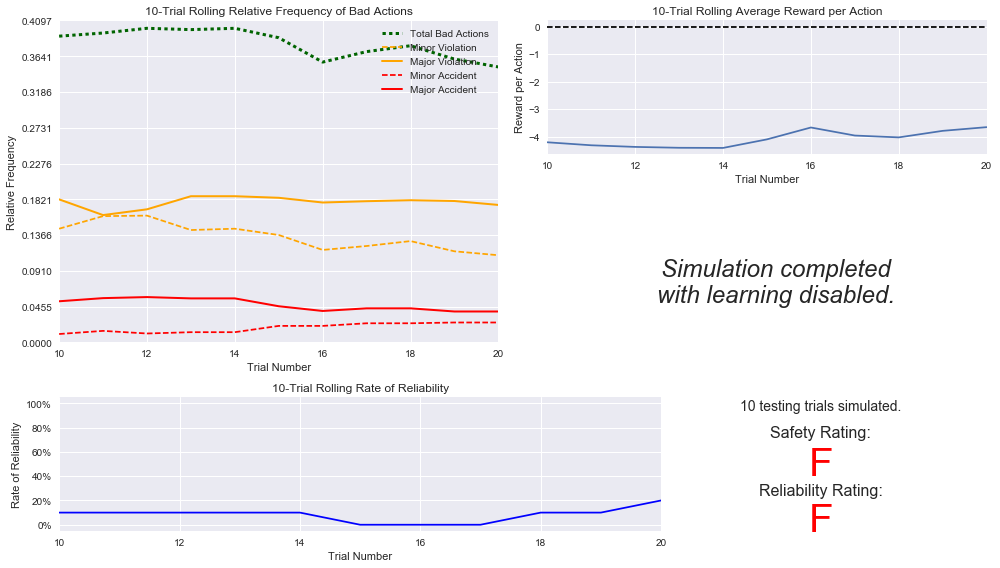

In [14]:
hide_code
# Load the 'sim_no-learning' log file from the initial simulation results
plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliability make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

---
### Answer 3
- Bad decisions (according to the "10-trial rolling relative frequency of bad actions" visualization):
  - the agent made bad decisions in approximately 35-41% percents of cases;
  - those bad decisions in about 1/8 of cases result in accidents.
  
  
- The Smartcab has chosen actions randomly between four variants (each of them can be good or bad depending on the situation on the road)  so this rate of the reliability make some sense.


- The "10-trial rolling average rewarding action" plot displays that on average the agent receives a negative reward between -4.5 and -3.5. It shows that the Smartcab has been penalized many times.


- According to the "10-trial rolling rate of reliability" plot, the results are between 0% and 20% so the outcome of results has not changed significantly.


- The Smartcab cannot be considered safe and reliable for its passengers: the safety rating and reliability rating are equal to "F". This fact indicates that the agent caused at least one major accident per run (the `'calculate_safety()'` function in `visuals.py`) and failed to reach the destination on time for at least 60% of trips (the `'calculate_reliability()'` function in `visuals.py`).

## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate?*

---
### Answer 4

- Waypoint: this parameter regulates the driving with the values [one block straight ahead, one block left, one block right, none]; it helps the agent to find out the next step towards the goal, this action can be optimal if there were no other constraints; so it captures efficiency.
- Traffic lights: this parameter with values [green, red] related to the environment, it needs to be included in states for the agent to learn traffic rules,  rewards, and as a result, safe driving.
- Cars at intersections (oncoming and from the left side): this parameter is related to the environment, and includes the direction of other cars at the intersection; it helps the agent to learn how it should react when a different agent behaves in a certain way at the intersection (according to the traffic rules); of course, it's important for safety as well.
- I have not included the deadline feature because I think on this stage, it does not consist the information needed to find the optimal way. Certainly, it does not affect safety.
- I did not use the information about cars at intersections from the right side because it does not affect the agent moves.

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the environment and how it is simulated, do you think the driving agent could learn a policy for each possible state of a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

---
### Answer 5  

The feature 'waypoint' can be one of three values: 'right', 'forward', 'left';  the value 'none' could be only in the case when the agent has reached its destination. Other features 'light', 'oncoming', 'left' has 2, 4, 4 possible values respectively. 

The number of possible combinations is equal to: 3 x 2 x 4 x 4 = 96

### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

In [16]:
hide_code
# functions build_state(), run() in the file agent.py, the variant for 5.1

class LearningAgent(Agent):
    """ An agent that learns to drive in the Smartcab world.
        This is the object you will be modifying. """ 

    def __init__(self, env, learning=False, epsilon=1.0, alpha=0.5):
        super(LearningAgent, self).__init__(env)     # Set the agent in the evironment 
        self.planner = RoutePlanner(self.env, self)  # Create a route planner
        self.valid_actions = self.env.valid_actions  # The set of valid actions

        # Set parameters of the learning agent
        self.learning = learning # Whether the agent is expected to learn
        self.Q = dict()          # Create a Q-table which will be a dictionary of tuples
        self.epsilon = epsilon   # Random exploration factor
        self.alpha = alpha       # Learning factor

        ###########
        ## TO DO ##
        ###########
        # Set any additional class parameters as needed
        self.trial = 0

    def reset(self, destination=None, testing=False):
        """ The reset function is called at the beginning of each trial.
            'testing' is set to True if testing trials are being used
            once training trials have completed. """

        # Select the destination as the new location to route to
        self.planner.route_to(destination)
        
        ########### 
        ## TO DO ##
        ###########
        # Update epsilon using a decay function of your choice
        # Update additional class parameters as needed
        # If 'testing' is True, set epsilon and alpha to 0
        self.trial += 1
        
        if testing:
            self.epsilon = 0
            self.alpha = 0
        else:
            # 6.1 default learning
            self.epsilon = self.epsilon - 0.05
            
        return None

    def build_state(self):
        """ The build_state function is called when the agent requests data from the 
            environment. The next waypoint, the intersection inputs, and the deadline 
            are all features available to the agent. """

        # Collect data about the environment  
        waypoint = self.planner.next_waypoint() # The next waypoint 
        inputs = self.env.sense(self)           # Visual input - intersection light and traffic
        deadline = self.env.get_deadline(self)  # Remaining deadline
    
        ########### 
        ## TO DO ##
        ###########
        
        # NOTE : you are not allowed to engineer eatures outside of the inputs available.
        # Because the aim of this project is to teach Reinforcement Learning, we have placed 
        # constraints in order for you to learn how to adjust epsilon and alpha, 
        # and thus learn about the balance between exploration and exploitation.
        # With the hand-engineered features, this learning process gets entirely negated.
        
        # Set 'state' as a tuple of relevant data for the agent         
        state = (waypoint, inputs['light'], inputs['oncoming'], inputs['left']) #(!!!)

        return state
    
    def get_maxQ(self, state):
        """ The get_max_Q function is called when the agent is asked to find the
            maximum Q-value of all actions based on the 'state' the smartcab is in. """

        ########### 
        ## TO DO ##
        ###########
        # Calculate the maximum Q-value of all actions for a given state

        maxQ = None

        return maxQ 

    def createQ(self, state):
        """ The createQ function is called when a state is generated by the agent. """

        ########### 
        ## TO DO ##
        ###########
        # When learning, check if the 'state' is not in the Q-table
        # If it is not, create a new dictionary for that state
        #   Then, for each action available, set the initial Q-value to 0.0

        return

    def choose_action(self, state):
        """ The choose_action function is called when the agent is asked to choose
            which action to take, based on the 'state' the smartcab is in. """

        # Set the agent state and default action
        self.state = state
        self.next_waypoint = self.planner.next_waypoint()
        action = random.choice(self.valid_actions)

        ########### 
        ## TO DO ##
        ###########
        # When not learning, choose a random action
        # When learning, choose a random action with 'epsilon' probability
        # Otherwise, choose an action with the highest Q-value for the current state
        # Be sure that when choosing an action with highest Q-value that 
        # you randomly select between actions that "tie".
        return action

    def learn(self, state, action, reward):
        """ The learn function is called after the agent completes an action and
            receives a reward. This function does not consider future rewards 
            when conducting learning. """

        ########### 
        ## TO DO ##
        ###########
        # When learning, implement the value iteration update rule
        #   Use only the learning rate 'alpha' (do not use the discount factor 'gamma')

        return

    def update(self):
        """ The update function is called when a time step is completed in the 
            environment for a given trial. This function will build the agent
            state, choose an action, receive a reward, and learn if enabled. """

        state = self.build_state()          # Get current state
        self.createQ(state)                 # Create 'state' in Q-table
        action = self.choose_action(state)  # Choose an action
        reward = self.env.act(self, action) # Receive a reward
        self.learn(state, action, reward)   # Q-learn

        return    
     
def run():
    """ Driving function for running the simulation. 
        Press ESC to close the simulation, or [SPACE] to pause the simulation. """

    ##############
    # Create the environment
    # Flags:
    #   verbose     - set to True to display additional output from the simulation
    #   num_dummies - discrete number of dummy agents in the environment, default is 100
    #   grid_size   - discrete number of intersections (columns, rows), default is (8, 6)
    env = Environment()
    
    ##############
    # Create the driving agent
    # Flags:
    #   learning   - set to True to force the driving agent to use Q-learning
    #    * epsilon - continuous value for the exploration factor, default is 1
    #    * alpha   - continuous value for the learning rate, default is 0.5
    agent = env.create_agent(LearningAgent)
    
    ##############
    # Follow the driving agent
    # Flags:
    #   enforce_deadline - set to True to enforce a deadline metric
    env.set_primary_agent(agent, enforce_deadline=True) #(!!!)

    ##############
    # Create the simulation
    # Flags:
    #   update_delay - continuous time (in seconds) between actions, default is 2.0 seconds
    #   display      - set to False to disable the GUI if PyGame is enabled
    #   log_metrics  - set to True to log trial and simulation results to /logs
    #   optimized    - set to True to change the default log file name
    sim = Simulator(env, log_metrics=True) #(!!!)
    
    ##############
    # Run the simulator
    # Flags:
    #   tolerance  - epsilon tolerance before beginning testing, default is 0.05 
    #   n_test     - discrete number of testing trials to perform, default is 0
    sim.run() #(!!!)

In [19]:
hide_code
# if __name__ == '__main__':
#     run()

''

$\color{#f05e1c}{The \ output \ of \ this \ code \ cell \ is \ in \ the \ file \ '5-2.txt'}$

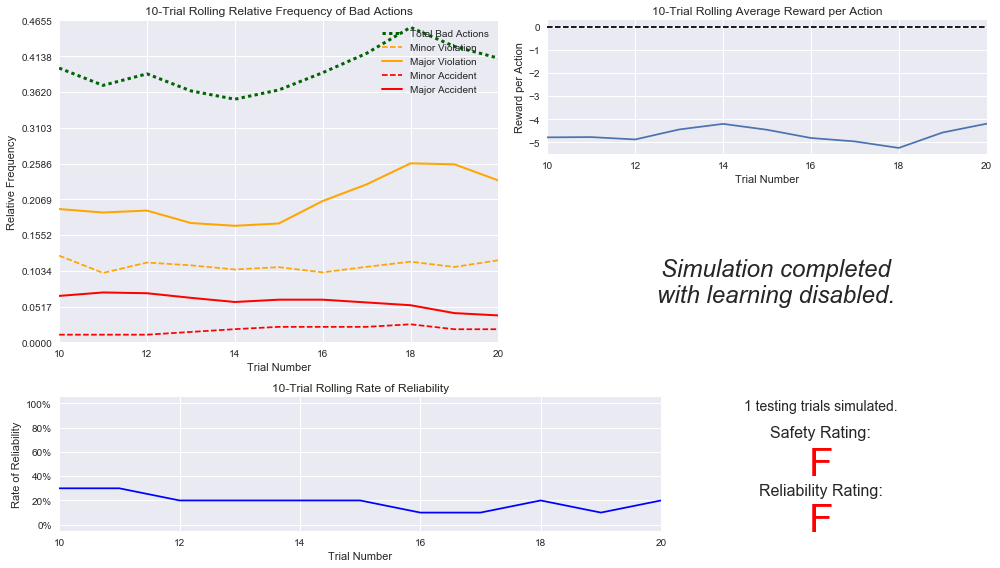

In [18]:
hide_code
# Load the 'sim_no-learning' file for the informed agent
plot_trials('sim_no-learning.csv')

## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the interative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 'action-1' : Qvalue-1, 'action-2' : Qvalue-2, ...},
  'state-2': {'action-1' : Qvalue-1, ...},
   ...}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.01). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

In [20]:
hide_code
# agent.py, the variant for 6.1

class LearningAgent(Agent):
    """ An agent that learns to drive in the Smartcab world.
        This is the object you will be modifying. """ 

    def __init__(self, env, learning=False, epsilon=1.0, alpha=0.5):
        super(LearningAgent, self).__init__(env)     # Set the agent in the evironment 
        self.planner = RoutePlanner(self.env, self)  # Create a route planner
        self.valid_actions = self.env.valid_actions  # The set of valid actions

        # Set parameters of the learning agent
        self.learning = learning # Whether the agent is expected to learn
        self.Q = dict()          # Create a Q-table which will be a dictionary of tuples
        self.epsilon = epsilon   # Random exploration factor
        self.alpha = alpha       # Learning factor

        ###########
        ## TO DO ##
        ###########
        # Set any additional class parameters as needed
        
        self.trial = 0 #(!!!)

    def reset(self, destination=None, testing=False):
        """ The reset function is called at the beginning of each trial.
            'testing' is set to True if testing trials are being used
            once training trials have completed. """

        # Select the destination as the new location to route to
        self.planner.route_to(destination)
        
        ########### 
        ## TO DO ##
        ###########
        # Update epsilon using a decay function of your choice
        # Update additional class parameters as needed
        # If 'testing' is True, set epsilon and alpha to 0
        
        #(!!!)
        
        self.trial += 1
        
        if testing:
            self.epsilon = 0
            self.alpha = 0
        else:
            # 6.1 default learning
            self.epsilon = self.epsilon - 0.05
            
        return None

    def build_state(self):
        """ The build_state function is called when the agent requests data from the 
            environment. The next waypoint, the intersection inputs, and the deadline 
            are all features available to the agent. """

        # Collect data about the environment
        waypoint = self.planner.next_waypoint() # The next waypoint 
        inputs = self.env.sense(self)           # Visual input - intersection light and traffic
        deadline = self.env.get_deadline(self)  # Remaining deadline

        ########### 
        ## TO DO ##
        ###########
        
        # NOTE : you are not allowed to engineer eatures outside of the inputs available.
        # Because the aim of this project is to teach Reinforcement Learning, we have placed 
        # constraints in order for you to learn how to adjust epsilon and alpha, 
        # and thus learn about the balance between exploration and exploitation.
        # With the hand-engineered features, this learning process gets entirely negated.
        
        # Set 'state' as a tuple of relevant data for the agent        
        state = (waypoint, inputs['light'], inputs['oncoming'], inputs['left'])
        
        self.createQ(state) #(!!!)
        
        return state

    def get_maxQ(self):
        """ The get_max_Q function is called when the agent is asked to find the
            maximum Q-value of all actions based on the 'state' the smartcab is in. """

        ########### 
        ## TO DO ##
        ###########
        # Calculate the maximum Q-value of all actions for a given state
        
        #(!!!)
        
        maxQ = 0
        actions = []

        for action in self.Q[self.state]:
            
            Qvalue = self.Q[self.state][action]
            
            if maxQ < Qvalue:
                maxQ = Qvalue
                del actions[:]
                actions.append(action)
                
            elif maxQ == Qvalue:
                actions.append(action)
        
        return maxQ, actions 

    def createQ(self, state):
        """ The createQ function is called when a state is generated by the agent. """

        ########### 
        ## TO DO ##
        ###########
        # When learning, check if the 'state' is not in the Q-table
        # If it is not, create a new dictionary for that state
        #   Then, for each action available, set the initial Q-value to 0.0
        
        #(!!!)
        
        if self.learning and state not in self.Q.keys():
            self.Q[state] = {'left':0.0, 'right':0.0, 'forward':0.0, None:0.0}

        return 

    def choose_action(self, state):
        """ The choose_action function is called when the agent is asked to choose
            which action to take, based on the 'state' the smartcab is in. """

        # Set the agent state and default action
        self.state = state
        self.next_waypoint = self.planner.next_waypoint()
#        action = random.choice(self.valid_actions)

        ########### 
        ## TO DO ##
        ###########
        # When not learning, choose a random action
        # When learning, choose a random action with 'epsilon' probability
        # Otherwise, choose an action with the highest Q-value for the current state
        # Be sure that when choosing an action with highest Q-value 
        # that you randomly select between actions that "tie".
        
        #(!!!)
        
        if self.learning:
            
            if self.epsilon > random.random():
                action = random.choice(self.valid_actions)
            else:
                action = random.choice(self.get_maxQ()[1])
                
        else:
            action = random.choice(self.valid_actions)
        
        return action

    def learn(self, state, action, reward):
        """ The learn function is called after the agent completes an action and
            receives a reward. This function does not consider future rewards 
            when conducting learning. """

        ########### 
        ## TO DO ##
        ###########
        # When learning, implement the value iteration update rule
        #   Use only the learning rate 'alpha' (do not use the discount factor 'gamma')
        
        #(!!!)
        if self.learning:
            self.Q[self.state][action] = (1 - self.alpha) * self.Q[self.state][action] + self.alpha * reward
            
        return 

    def update(self):
        """ The update function is called when a time step is completed in the 
            environment for a given trial. This function will build the agent
            state, choose an action, receive a reward, and learn if enabled. """

        state = self.build_state()          # Get current state
        self.createQ(state)                 # Create 'state' in Q-table
        action = self.choose_action(state)  # Choose an action
        reward = self.env.act(self, action) # Receive a reward
        self.learn(state, action, reward)   # Q-learn

        return 
        
def run():
    """ Driving function for running the simulation. 
        Press ESC to close the simulation, or [SPACE] to pause the simulation. """

    ##############
    # Create the environment
    # Flags:
    #   verbose     - set to True to display additional output from the simulation
    #   num_dummies - discrete number of dummy agents in the environment, default is 100
    #   grid_size   - discrete number of intersections (columns, rows), default is (8, 6)
    env = Environment()
    
    ##############
    # Create the driving agent
    # Flags:
    #   learning   - set to True to force the driving agent to use Q-learning
    #    * epsilon - continuous value for the exploration factor, default is 1
    #    * alpha   - continuous value for the learning rate, default is 0.5
    agent = env.create_agent(LearningAgent, learning=True) #(!!!)
    
    ##############
    # Follow the driving agent
    # Flags:
    #   enforce_deadline - set to True to enforce a deadline metric
    env.set_primary_agent(agent, enforce_deadline=True) #(!!!)

    ##############
    # Create the simulation
    # Flags:
    #   update_delay - continuous time (in seconds) between actions, default is 2.0 seconds
    #   display      - set to False to disable the GUI if PyGame is enabled
    #   log_metrics  - set to True to log trial and simulation results to /logs
    #   optimized    - set to True to change the default log file name
    sim = Simulator(env, update_delay=0.1, log_metrics=True) #(!!!)
    
    ##############
    # Run the simulator
    # Flags:
    #   tolerance  - epsilon tolerance before beginning testing, default is 0.05 
    #   n_test     - discrete number of testing trials to perform, default is 0
    sim.run(n_test=10) #(!!!)

In [23]:
hide_code
# if __name__ == '__main__':
#     run()

''

$\color{#f05e1c}{The \ output \ of \ this \ code \ cell \ is \ in \ the \ file \ '6-2.txt'}$

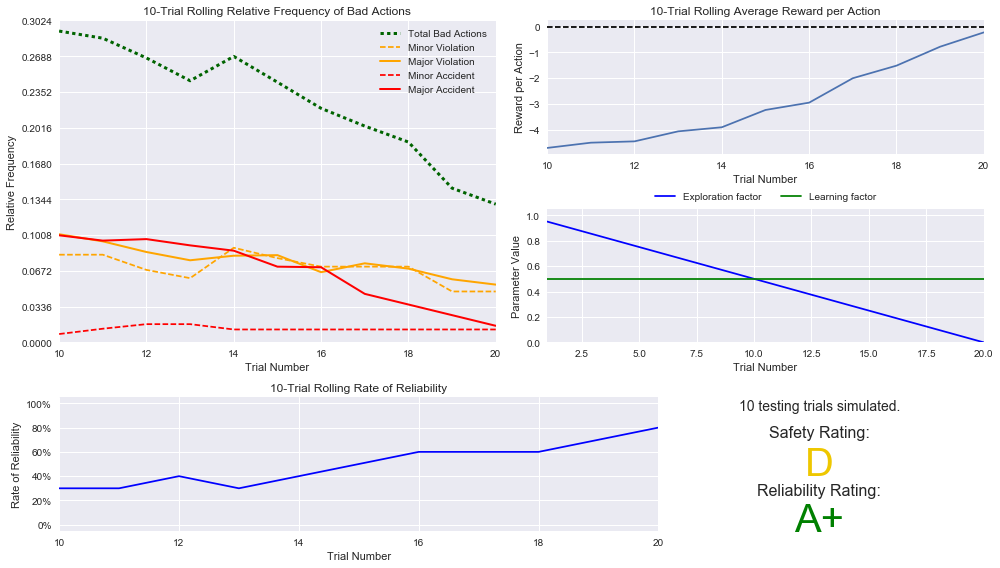

In [22]:
hide_code
# Load the 'sim_default-learning' file from the default Q-Learning simulation
plot_trials('sim_default-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar to the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

---
### Answer 6
- Comparing observations: the most of the observations have a significant difference.
  - The safety rating is equal to "F" for the basic driving agent and the default Q-Learning agent, but the reliability rating has a huge difference: "F" - for the basic driving agent and "A" - for the default Q-Learning agent.
  - In the second case, we could see a decrease of bad actions and increase of rewards, and there is no progress in these spheres in the first case.
  

- In our code, the default $\epsilon$ tolerance is equal to 0.05, and the exploration factor is reduced by 0.05 on every training step. It corresponds to the 20 training trials performed by the agent: 1 / 0.05 = 20.


- In the second diagram on the right-hand side, we can see a plot of parameter values. The exploration factor is represented by the straight line and decreases at a constant rate according to the given decaying function.


- With increasing the number of training trials in the case of the default Q-Learning agent, the number of bad actions was significantly decreasing to the level about 15% and the average reward was improved but did not become positive in the end.


- For the default Q-Learning agent the reliability had really improved till the grade of "A+" and it indicates the effective learning the move rules in the grid space. The safety rating is equal to "D", but the frequency of bad actions had fallen.

## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the impliciations it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

In [24]:
hide_code
# agent.py, the final variant

class LearningAgent(Agent):
    """ An agent that learns to drive in the Smartcab world.
        This is the object you will be modifying. """ 

    def __init__(self, env, learning=False, epsilon=1.0, alpha=0.5):
        super(LearningAgent, self).__init__(env)     # Set the agent in the evironment 
        self.planner = RoutePlanner(self.env, self)  # Create a route planner
        self.valid_actions = self.env.valid_actions  # The set of valid actions

        # Set parameters of the learning agent
        self.learning = learning # Whether the agent is expected to learn
        self.Q = dict()          # Create a Q-table which will be a dictionary of tuples
        self.epsilon = epsilon   # Random exploration factor
        self.alpha = alpha       # Learning factor

        ###########
        ## TO DO ##
        ###########
        # Set any additional class parameters as needed
        self.trial = 0

    def reset(self, destination=None, testing=False):
        """ The reset function is called at the beginning of each trial.
            'testing' is set to True if testing trials are being used
            once training trials have completed. """

        # Select the destination as the new location to route to
        self.planner.route_to(destination)
        
        ########### 
        ## TO DO ##
        ###########
        # Update epsilon using a decay function of your choice
        # Update additional class parameters as needed
        # If 'testing' is True, set epsilon and alpha to 0
        self.trial += 1
        
        if testing:
            self.epsilon = 0
            self.alpha = 0
        else:
            # 6.1 default learning
            self.epsilon = self.epsilon - 0.05
            
        return None

    def build_state(self):
        """ The build_state function is called when the agent requests data from the 
            environment. The next waypoint, the intersection inputs, and the deadline 
            are all features available to the agent. """

        # Collect data about the environment
        waypoint = self.planner.next_waypoint() # The next waypoint 
        inputs = self.env.sense(self)           # Visual input - intersection light and traffic
        deadline = self.env.get_deadline(self)  # Remaining deadline

        ########### 
        ## TO DO ##
        ###########
        
        # NOTE : you are not allowed to engineer eatures outside of the inputs available.
        # Because the aim of this project is to teach Reinforcement Learning, we have placed 
        # constraints in order for you to learn how to adjust epsilon and alpha, 
        # and thus learn about the balance between exploration and exploitation.
        # With the hand-engineered features, this learning process gets entirely negated.
        
        # Set 'state' as a tuple of relevant data for the agent        
        state = (waypoint, inputs['light'], inputs['oncoming'], inputs['left'])
        
        self.createQ(state)
        
        return state

    def get_maxQ(self):
        """ The get_max_Q function is called when the agent is asked to find the
            maximum Q-value of all actions based on the 'state' the smartcab is in. """

        ########### 
        ## TO DO ##
        ###########
        # Calculate the maximum Q-value of all actions for a given state
        maxQ = 0
        actions = []

        for action in self.Q[self.state]:
            
            Qvalue = self.Q[self.state][action]
            
            if maxQ < Qvalue:
                maxQ = Qvalue
                del actions[:]
                actions.append(action)
                
            elif maxQ == Qvalue:
                actions.append(action)
        
        return maxQ, actions 

    def createQ(self, state):
        """ The createQ function is called when a state is generated by the agent. """

        ########### 
        ## TO DO ##
        ###########
        # When learning, check if the 'state' is not in the Q-table
        # If it is not, create a new dictionary for that state
        #   Then, for each action available, set the initial Q-value to 0.0
        if self.learning and state not in self.Q.keys():
            self.Q[state] = {'left':0.0, 'right':0.0, 'forward':0.0, None:0.0}

        return 

    def choose_action(self, state):
        """ The choose_action function is called when the agent is asked to choose
            which action to take, based on the 'state' the smartcab is in. """

        # Set the agent state and default action
        self.state = state
        self.next_waypoint = self.planner.next_waypoint()
#        action = random.choice(self.valid_actions)

        ########### 
        ## TO DO ##
        ###########
        # When not learning, choose a random action
        # When learning, choose a random action with 'epsilon' probability
        # Otherwise, choose an action with the highest Q-value for the current state
        # Be sure that when choosing an action with highest Q-value that 
        # you randomly select between actions that "tie".
        if self.learning:
            
            if self.epsilon > random.random():
                action = random.choice(self.valid_actions)
            else:
                action = random.choice(self.get_maxQ()[1])
                
        else:
            action = random.choice(self.valid_actions)
        
        return action

    def learn(self, state, action, reward):
        """ The learn function is called after the agent completes an action and
            receives a reward. This function does not consider future rewards 
            when conducting learning. """

        ########### 
        ## TO DO ##
        ###########
        # When learning, implement the value iteration update rule
        #   Use only the learning rate 'alpha' (do not use the discount factor 'gamma')
        if self.learning:
            self.Q[self.state][action] = (1 - self.alpha) * self.Q[self.state][action] + self.alpha * reward
            
        return 

    def update(self):
        """ The update function is called when a time step is completed in the 
            environment for a given trial. This function will build the agent
            state, choose an action, receive a reward, and learn if enabled. """

        state = self.build_state()          # Get current state
        self.createQ(state)                 # Create 'state' in Q-table
        action = self.choose_action(state)  # Choose an action
        reward = self.env.act(self, action) # Receive a reward
        self.learn(state, action, reward)   # Q-learn

        return         

def run():
    """ Driving function for running the simulation. 
        Press ESC to close the simulation, or [SPACE] to pause the simulation. """

    ##############
    # Create the environment
    # Flags:
    #   verbose     - set to True to display additional output from the simulation
    #   num_dummies - discrete number of dummy agents in the environment, default is 100
    #   grid_size   - discrete number of intersections (columns, rows), default is (8, 6)
    env = Environment()
    
    ##############
    # Create the driving agent
    # Flags:
    #   learning   - set to True to force the driving agent to use Q-learning
    #    * epsilon - continuous value for the exploration factor, default is 1
    #    * alpha   - continuous value for the learning rate, default is 0.5
    agent = env.create_agent(LearningAgent, learning=True, epsilon=5, alpha=0.1)
    
    ##############
    # Follow the driving agent
    # Flags:
    #   enforce_deadline - set to True to enforce a deadline metric
    env.set_primary_agent(agent, enforce_deadline=True)

    ##############
    # Create the simulation
    # Flags:
    #   update_delay - continuous time (in seconds) between actions, default is 2.0 seconds
    #   display      - set to False to disable the GUI if PyGame is enabled
    #   log_metrics  - set to True to log trial and simulation results to /logs2
    #   optimized    - set to True to change the default log file name
    sim = Simulator(env, update_delay=0.1, log_metrics=True, optimized=True)
    
    ##############
    # Run the simulator
    # Flags:
    #   tolerance  - epsilon tolerance before beginning testing, default is 0.05 
    #   n_test     - discrete number of testing trials to perform, default is 0
    sim.run(n_test=20, tolerance=0.02)

In [27]:
hide_code
# if __name__ == '__main__':
#     run()

''

$\color{#f05e1c}{The \ output \ of \ this \ code \ cell \ is \ in \ the \ file \ '7-2.txt'}$

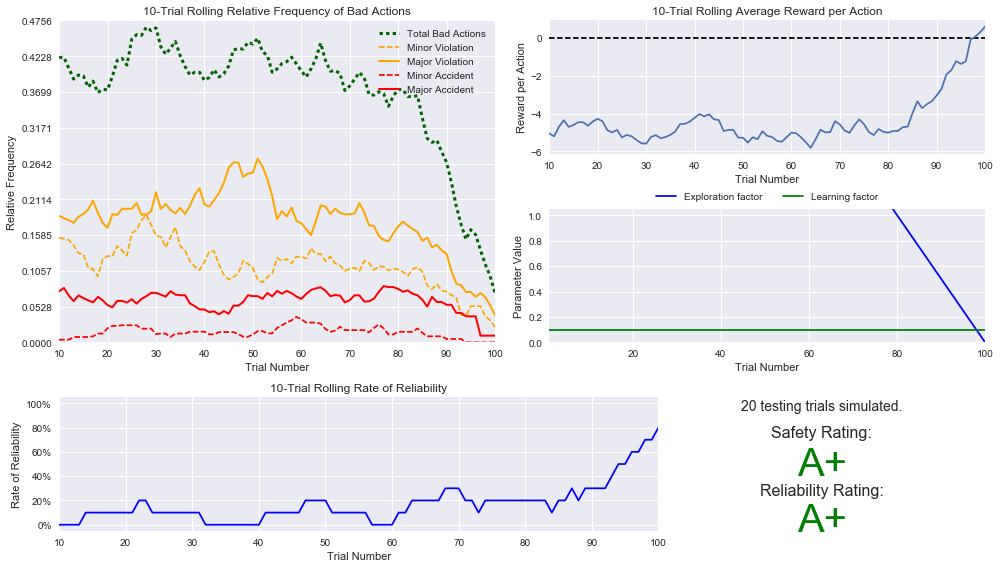

In [26]:
hide_code
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
plot_trials('sim_improved-learning.csv')

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

---
### Answer 7
- I have used the linear decay function for epsilon.

- The agent completed 100 training trials before testing, they became successful at the end of the training.

- I have used alpha=0.1 and epsilon-tolerance=0.05. The chosen epsilon-tolerance needs to have enough quantity of trials for training (at least not less than 96). The alpha-value was chosen not so small to give the agent more freedom in actions.
  
- The agent has a great progress in all spheres as a result of improvement was made with this Q-Learner when compared to the default Q-Learner. 
  - The reward became positive.
  - A significant reduction in bad actions of the agent was achieved.
  - The reliability had really improved till the grade of "A+"; the safety rating became equal to "A+"as well. Both indicators had reached their maximum values.
  
- The driving agent has successfully learned an appropriate policy: all testing trial had the positive results.

- I have completely satisfied with the safety and reliability ratings of the *Smartcab*: they have the highest possible level.

### Define an Optimal Policy
Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8
Provide a few examples (using the states you've defined) of what an optimal policy for this problem would look like. Afterward, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ Provide an example of a state and all state-action rewards recorded, and explain why it is the correct policy.

---
### Answer 8
The most of the steps in the simulation correspond to the optimal policy and they are correct for the given state. 

In this case, the optimality can be described in the following way: the agent moving should be within the borders of the traffic rules, match the current situation on the road, reach the destination, and have a positive reward as a result.

More formally: 

|&#x1F6A5; &nbsp; **the traffic light is red**||||&#x1F6A5; &nbsp; **the traffic light is green**||||
|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|
|moving forward or turning left|turning right|||moving forward or turning right|turning left|||
| |no car on the left|car on the left|| |oncoming car||no oncoming car|
| | |which is not moving forward|which is moving forward| |which is not moving forward|which is moving forward| |
|**stop**|**move**|**move**|**stop**|**move**|**move**|**stop**|**move**|
|&#x26D4;|&#x2705;|&#x2705;|&#x26D4;|&#x2705;|&#x2705;|&#x26D4;|&#x2705;|

Let's have a look at the concrete examples:

- &#x1F695; &nbsp; *`('right', 'red', 'forward', None)`*
  - forward : -7.72
  - None : 0.48
  - right : 1.21
  - left : -5.80
- &#x1F58C; &nbsp; The waypoint is 'right', the light is 'red', there is a car from the oncoming direction, there are no cars from the left side. In this case, the ideal action is 'right' has the highest positive weight (the agent can move to the goal), and the two most disruptive actions are severely penalized: any movement would be a violation.

- &#x1F695; &nbsp; *`('forward', 'green', 'forward', None)`*
  - forward : 0.87
  - None : -2.12
  - right : 0.13
  - left : 0.26
- &#x1F58C; &nbsp; The waypoint is 'forward', the light is 'green', there is a car from the oncoming direction, there are no cars from the left side. In this case, the ideal action is 'forward' has the highest positive weight (the agent can move to the goal), and the action 'None' is severely penalized: no move is a bad action.

Some actions do not look correct for the given state.

- &#x1F695; &nbsp; *`('forward', 'red', 'forward', None)`*
  - forward : -16.17
  - None : 0.51
  - right : -6.76
  - left : -16.46
- &#x1F58C; &nbsp; The waypoint is 'forward', the light is 'red', there are no cars from the left side, there is a car from the oncoming direction (moving forward). The action 'forward' could be classified as 'bad' and could be a reason for the accident.

##  Optional: Future Rewards - Discount Factor `gamma`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, **`gamma`** in the implementation. Including future rewards in the algorithm is used to aid in propogating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

### Answer 9
- &#x1F695; &nbsp; The Agent

The decisions made by the agent in each state do not depend on previous or future positions since they are not <b>connected by information</b>. The agent does not know about the number of cars, traffic light, etc. at the next intersections, and therefore he is deprived of the opportunity to improve his results by planning the route as a whole. At each intersection, the decision is made independently of all the others, and so there is no sense in <b>long-term rewards</b>.

- &#x1F6A6; &nbsp; The Environment

The environment is <b>not deterministic</b>. With each new trial, it is created anew under the same laws, but without information on previous variants. Hence, the long-term reward associated with the agent's particular position in this environment also loses meaning with transitions to the next tests.